In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

In [2]:
def semi_major_axis_in_stellar_radii(semi_major_axis, R_star):
    """
    Converting the semi-major axis (AU) to (Stellar radii)

    Parameters
    ----------
    semi_major_axis : float
        Semi-major axis of the planet in AU.

    R_star : float
        Stellar radius in R_sun.

    Returns
    -------
    a_stellar_radii : float
        Semi-major axis of the planet in stellar radii.
    """
    #1 AU = 215.032 R_Sun

    a_stellar_radii = semi_major_axis * 215.032 / R_star

    return a_stellar_radii

In [3]:
TIC = 'TIC 181949561' #WASP-39b / TIC 181949561

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()

print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))
#Sector 12 and sector 38
lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 1 objects:
    0: <TessLightCurve LABEL="TIC 181949561" SECTOR=51 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [4]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

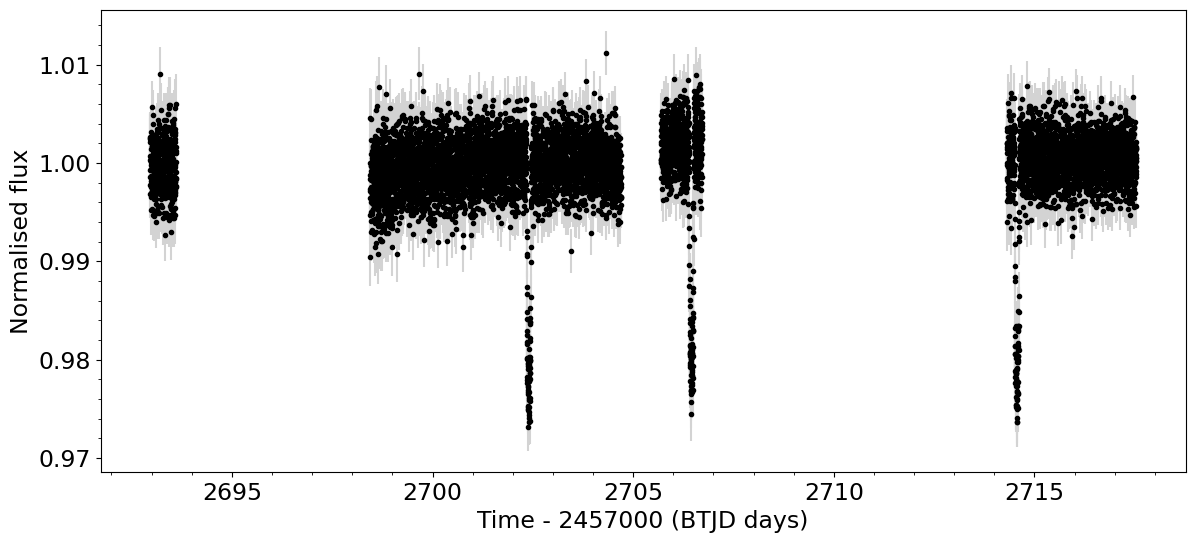

In [5]:
fig, ax = plt.subplots(1, figsize=(14,6))
plt.errorbar(t, flux_data, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [6]:
filename = "wasp_39b_flat_samples.p"
with open(filename, "rb") as f:
    flat_samples = pickle.load(f)
f.close()

In [7]:
# ld_data_path = r"/data/cluster4/rk19047/exotic_ld_data"
ld_data_path = r"C:\\Users\\Student\\Documents\\exotic_ld_data"

ld_model = 'mps1' # Stellar models grid.

M_H = 0.01 # Metallicty [dex]. [Fe/H]
#Mancini et al. 2018

Teff = 5485 # Effective temperature [K].
#Mancini et al. 2018

logg = 4.453 # Surface gravity [dex].
#Mancini et al. 2018

sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)

# Start and end of wavelength interval [angstroms].
wavelength_range = [6000., 10000.]

# Instrument mode.
mode = 'TESS'

u1, u2 = sld.compute_quadratic_ld_coeffs(wavelength_range, mode)
print([u1, u2])

[0.35092681757927346, 0.22991353177818383]


In [8]:
model_T0 = np.percentile(flat_samples[:, 0], 50) #Mid-transit time (Days)
model_Rp = np.percentile(flat_samples[:, 1], 50) #Rp/Rs
model_per = np.percentile(flat_samples[:, 2], 50) #Orbital period (Days)
model_inc = np.percentile(flat_samples[:, 3], 50) #Orbital inclination (Deg)
model_a = np.percentile(flat_samples[:, 4], 50) #a/R

prior_Rs = 0.939 #R_sun, Mancini et al. 2018

model_params = batman.TransitParams()
model_params.t0 = model_T0                                          #time of inferior conjunction
model_params.per = model_per                                        #orbital period (days)
model_params.rp = model_Rp                #planet radius (in units of stellar radii)
model_params.a = model_a #semi-major axis (in units of stellar radii))
model_params.inc = model_inc                                     #orbital inclination (in degrees)
model_params.ecc = 0.0                                         #eccentricity
model_params.w = 90.                                          #longitude of periastron (in degrees)
model_params.limb_dark = "quadratic"                          #limb darkening model
model_params.u = [u1, u2]                          #limb darkening coefficients [u1, u2, u3, u4]

t_range = np.arange(min(t),max(t), 0.0013889) #2 minutes = 0.0013889 day
m = batman.TransitModel(model_params, t_range)
model_flux = m.light_curve(model_params)

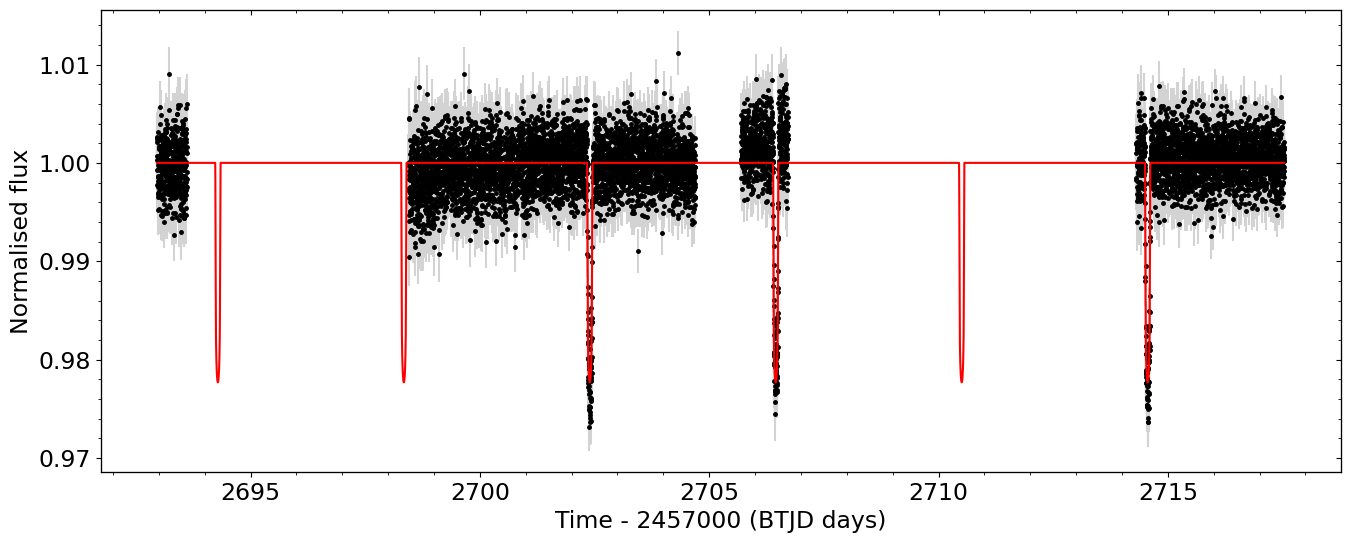

In [16]:
fig, ax = plt.subplots(1, figsize=(16,6))

ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.plot(t_range, model_flux, color='Red', zorder=10)

ax.set_ylabel("Normalised flux", size=17)
ax.set_xlabel("Time - 2457000 (BTJD days)", size=17)

# Mirror y
axA = ax.twinx()
axA.set_ylim(ax.get_ylim())
axA.get_yaxis().set_ticklabels([])
axA.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axB = ax.twiny()
axB.set_xlim(ax.get_xlim())
axB.get_xaxis().set_ticklabels([])
axB.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axB.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axA.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()